# Setup

In [1]:
from dask.distributed import Client

client = Client("tls://192.168.204.108:8786")
client

<Client: 'tls://192.168.204.108:8786' processes=1 threads=1, memory=3.50 GiB>

In [2]:
import numpy as np
import awkward as ak
import hist
from coffea import processor
from pprint import pprint

class DiObjectMass(processor.ProcessorABC):
    def __init__(self, object_1='Jet', object_2='Jet', bins=None, extra_cut=''):
        self.run_dict = {
            'thresholds' : {
                '100hz' : {'name'  : '100 Hz', 'score' : 1280.375},
                '1khz'  : {'name'  : '1 kHz', 'score' : 982.3125},
                '5khz'  : {'name'  : '5 kHz', 'score' : 734.8125},
                '10khz' : {'name'  : '10 kHz', 'score' : 610.8125},
            },
            'labels' : {'Jet' : 
                            {'label' : 'j'},
                        'Electron' : 
                            {'label' : 'e'},
                       
                        'Muon' : 
                            {'label' : '\mu'},
                       }
        }

        self.sorted_keys = sorted(self.run_dict['thresholds'], key=lambda i: self.run_dict['thresholds'][i]['score'])
        self.isSame = object_1==object_2
        self.object_1 = object_1
        self.object_2 = object_2
        self.extra_cut = extra_cut
        self.bins = bins if bins else (1000,0,1000) 

    def process(self, events):
        dataset = events.metadata['dataset']
        cutflow = {'start': len(events)}

        # # require trigger
        # events = events[
        #     # https://twiki.cern.ch/twiki/bin/view/CMS/MuonHLT2018
        #     events.HLT.Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8
        # ]
        # cutflow['trigger'] = len(events)
        
        events['obj1'] = getattr(events, self.object_1)
        events['obj2'] = getattr(events, self.object_2)
       
        diObjMask = (ak.num(events.obj1) >= 2) if self.isSame else ((ak.num(events.obj1) >= 1) & (ak.num(events.obj2) >= 1))
        events = events[diObjMask]
        cutflow['diObj'] = len(events)
        
        events['diObj'] = events.obj1[:, 0] + (events.obj1[:, 1] if self.isSame else events.obj2[:, 0])
        
        hist_dict = {}
        for k in self.sorted_keys:
            axo = events.axol1tl
            events = events[axo.score >= self.run_dict['thresholds'][k]['score']]
            cutflow[f'score_{k}'] = len(events)
            
            h = hist.Hist.new \
                .Reg(*self.bins, label='$m_{'+self.run_dict['labels'][self.object_1]['label']+self.run_dict['labels'][self.object_2]['label']+'}$ [GeV]') \
                .Double() \
                .fill(events.diObj.mass)
            hist_dict[f'm{self.object_1}{self.object_2}_{k}'] = h
                    
        return {
            dataset: {
                'entries': len(events),
                'cutflow': cutflow,
                'hists' : hist_dict,
            }
        }

    def postprocess(self, accumulator):
        return accumulator
        
proc_args = {'schema': processor.NanoAODSchema, 'client': client}

# Processing

In [ ]:
# Di-Jet Mass

mjj_result = processor.run_uproot_job(
    'axol1tl_filelist.json',
    'Events',
    DiObjectMass(object_1='Jet', object_2='Jet', bins=(30,0,1000)),
    processor.dask_executor,
    proc_args,
    chunksize=10000,
)
pprint(mjj_result)

In [ ]:
# Di-Muon Mass

mmumu_result = processor.run_uproot_job(
    'axol1tl_filelist.json',
    'Events',
    DiObjectMass(object_1='Muon', object_2='Muon', bins=(30,0,100)),
    processor.dask_executor,
    proc_args,
    chunksize=10000,
)
pprint(mmumu_result)

In [3]:
# Di-Electron Mass

mee_result = processor.run_uproot_job(
    'axol1tl_filelist.json',
    'Events',
    DiObjectMass(object_1='Electron', object_2='Electron', bins=(30,0,125)),
    processor.dask_executor,
    proc_args,
    chunksize=10000,
)
pprint(mee_result)

[                                        ] | 0% Completed |  0.0s

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


{'EphZeroBias_2023C': {'cutflow': {'diObj': 134619,ompleted |  2min  5.1s
                                   'score_100hz': 5,
                                   'score_10khz': 341,
                                   'score_1khz': 29,
                                   'score_5khz': 167,
                                   'start': 28369216},
                       'entries': 5,
                       'hists': {'mElectronElectron_100hz': Hist(Regular(30, 0, 125, label='$m_{ee}$ [GeV]'), storage=Double()) # Sum: 3.0 (5.0 with flow),
                                 'mElectronElectron_10khz': Hist(Regular(30, 0, 125, label='$m_{ee}$ [GeV]'), storage=Double()) # Sum: 331.0 (341.0 with flow),
                                 'mElectronElectron_1khz': Hist(Regular(30, 0, 125, label='$m_{ee}$ [GeV]'), storage=Double()) # Sum: 27.0 (29.0 with flow),
                                 'mElectronElectron_5khz': Hist(Regular(30, 0, 125, label='$m_{ee}$ [GeV]'), storage=Double()) # Sum: 159.0 (167.0

In [3]:
# Jet-Muon Mass

mjmu_result = processor.run_uproot_job(
    'axol1tl_filelist.json',
    'Events',
    DiObjectMass(object_1='Jet', object_2='Muon', bins=(30,0,500)),
    processor.dask_executor,
    proc_args,
    chunksize=10000,
)
pprint(mjmu_result)

[                                        ] | 0% Completed |  0.0s

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


{'EphZeroBias_2023C': {'cutflow': {'diObj': 3219044,mpleted |  2min  9.5s
                                   'score_100hz': 18,
                                   'score_10khz': 1349,
                                   'score_1khz': 131,
                                   'score_5khz': 654,
                                   'start': 28369216},
                       'entries': 18,
                       'hists': {'mJetMuon_100hz': Hist(Regular(30, 0, 500, label='$m_{j\\mu}$ [GeV]'), storage=Double()) # Sum: 18.0,
                                 'mJetMuon_10khz': Hist(Regular(30, 0, 500, label='$m_{j\\mu}$ [GeV]'), storage=Double()) # Sum: 1341.0 (1349.0 with flow),
                                 'mJetMuon_1khz': Hist(Regular(30, 0, 500, label='$m_{j\\mu}$ [GeV]'), storage=Double()) # Sum: 130.0 (131.0 with flow),
                                 'mJetMuon_5khz': Hist(Regular(30, 0, 500, label='$m_{j\\mu}$ [GeV]'), storage=Double()) # Sum: 648.0 (654.0 with flow)}},
 'GluGluHToGG_M-

In [3]:
# Jet-Electron Mass

mje_result = processor.run_uproot_job(
    'axol1tl_filelist.json',
    'Events',
    DiObjectMass(object_1='Jet', object_2='Electron', bins=(30,0,500)),
    processor.dask_executor,
    proc_args,
    chunksize=10000,
)
pprint(mje_result)

[                                        ] | 0% Completed |  0.0s

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


{'EphZeroBias_2023C': {'cutflow': {'diObj': 1773017,mpleted |  2min  1.6s
                                   'score_100hz': 17,
                                   'score_10khz': 1439,
                                   'score_1khz': 126,
                                   'score_5khz': 682,
                                   'start': 28369216},
                       'entries': 17,
                       'hists': {'mJetElectron_100hz': Hist(Regular(30, 0, 500, label='$m_{je}$ [GeV]'), storage=Double()) # Sum: 15.0 (17.0 with flow),
                                 'mJetElectron_10khz': Hist(Regular(30, 0, 500, label='$m_{je}$ [GeV]'), storage=Double()) # Sum: 1428.0 (1439.0 with flow),
                                 'mJetElectron_1khz': Hist(Regular(30, 0, 500, label='$m_{je}$ [GeV]'), storage=Double()) # Sum: 124.0 (126.0 with flow),
                                 'mJetElectron_5khz': Hist(Regular(30, 0, 500, label='$m_{je}$ [GeV]'), storage=Double()) # Sum: 677.0 (682.0 with flow

# Save/Load

In [5]:
# Save/Load Results
from coffea.util import save, load

doSave = True
doLoad = True

if doSave:
    try:
        save(mjj_result,'mjj_result.coffea')
    except NameError as e:
        print(e.args[0])
    try:
        save(mmumu_result,'mmumu_result.coffea')
    except NameError as e:
        print(e.args[0])
    try:
        save(mee_result,'mee_result.coffea')
    except NameError as e:
        print(e.args[0])
    try:
        save(mjmu_result,'mjmu_result.coffea')
    except NameError as e:
        print(e.args[0])
    try:
        save(mje_result,'mje_result.coffea')
    except NameError as e:
        print(e.args[0])
if doLoad:
    try:
        mjj_result = load('mjj_result.coffea')
    except FileNotFoundError as e:
        print(e.args[1],':', e.filename)
    try:
        mmumu_result = load('mmumu_result.coffea')
    except FileNotFoundError as e:
        print(e.args[1],':', e.filename)
    try:
        mee_result = load('mee_result.coffea')
    except FileNotFoundError as e:
        print(e.args[1],':', e.filename)
    try:
        mjmu_result = load('mjmu_result.coffea')
    except FileNotFoundError as e:
        print(e.args[1],':', e.filename)
    try:
        mje_result = load('mje_result.coffea')
    except FileNotFoundError as e:
        print(e.args[1],':', e.filename)


# Plotting

In [6]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.dpi'] = 50
hep.style.use('CMS')
wgt = 11

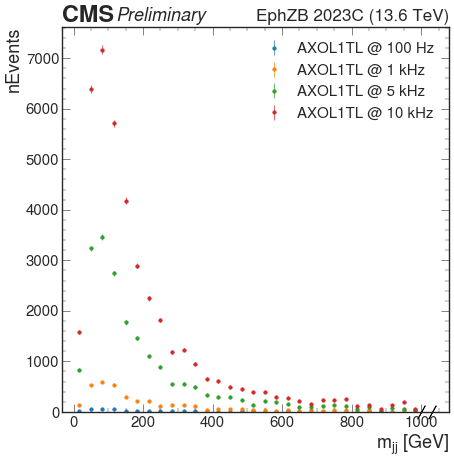

In [7]:
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=True, lumi=None, year='EphZB 2023C', com=13.6)
(mjj_result['EphZeroBias_2023C']['hists']['mJetJet_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz')
(mjj_result['EphZeroBias_2023C']['hists']['mJetJet_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz')
(mjj_result['EphZeroBias_2023C']['hists']['mJetJet_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz')
(mjj_result['EphZeroBias_2023C']['hists']['mJetJet_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz')
# ax.set_xlim(0, 800)
# plt.yscale('log')
plt.ylabel('nEvents', loc='top')
ax.legend();

In [22]:
(mjj_result['EphZeroBias_2023C']['hists']['mJetJet_10khz'] * wgt).to_numpy()

(array([1573., 6391., 7172., 5709., 4180., 2893., 2244., 1815., 1188.,
        1232.,  957.,  660.,  605.,  495.,  462.,  396.,  396.,  286.,
         275.,  220.,  165.,  231.,  242.,  253.,  121.,  132.,   55.,
         143.,  198.,   55.]),
 array([   0.        ,   33.33333333,   66.66666667,  100.        ,
         133.33333333,  166.66666667,  200.        ,  233.33333333,
         266.66666667,  300.        ,  333.33333333,  366.66666667,
         400.        ,  433.33333333,  466.66666667,  500.        ,
         533.33333333,  566.66666667,  600.        ,  633.33333333,
         666.66666667,  700.        ,  733.33333333,  766.66666667,
         800.        ,  833.33333333,  866.66666667,  900.        ,
         933.33333333,  966.66666667, 1000.        ]))

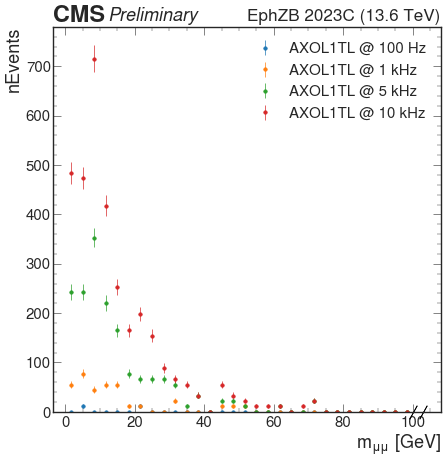

In [26]:
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=True, lumi=None, year='EphZB 2023C', com=13.6)
(mmumu_result['EphZeroBias_2023C']['hists']['mMuonMuon_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz')
(mmumu_result['EphZeroBias_2023C']['hists']['mMuonMuon_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz')
(mmumu_result['EphZeroBias_2023C']['hists']['mMuonMuon_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz')
(mmumu_result['EphZeroBias_2023C']['hists']['mMuonMuon_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz')
# ax.set_xlim(0, 100)
# plt.yscale('log')
plt.ylabel('nEvents', loc='top')
ax.legend();

NameError: name 'mee_result' is not defined

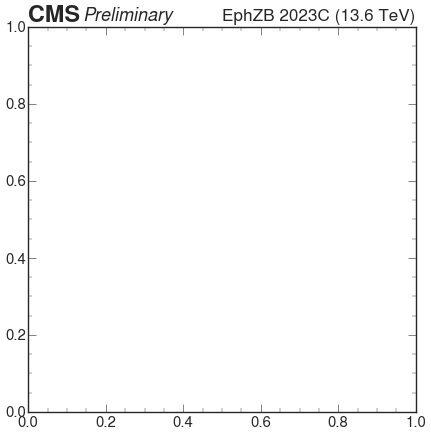

In [27]:
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=True, lumi=None, year='EphZB 2023C', com=13.6)
(mee_result['EphZeroBias_2023C']['hists']['mElectronElectron_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz')
(mee_result['EphZeroBias_2023C']['hists']['mElectronElectron_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz')
(mee_result['EphZeroBias_2023C']['hists']['mElectronElectron_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz')
(mee_result['EphZeroBias_2023C']['hists']['mElectronElectron_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz')
# ax.set_xlim(0, 200)
plt.ylabel('nEvents', loc='top')
ax.legend();

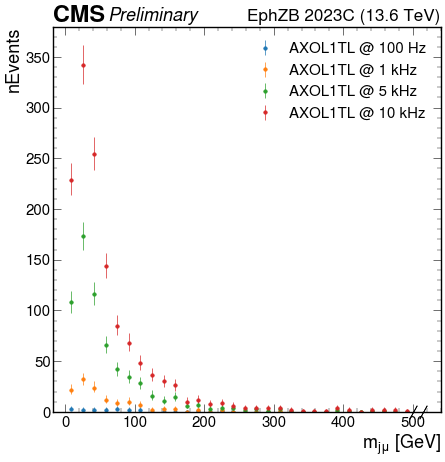

In [107]:
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=True, lumi=None, year='EphZB 2023C', com=13.6)
(mjmu_result['EphZeroBias_2023C']['hists']['mJetMuon_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz')
(mjmu_result['EphZeroBias_2023C']['hists']['mJetMuon_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz')
(mjmu_result['EphZeroBias_2023C']['hists']['mJetMuon_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz')
(mjmu_result['EphZeroBias_2023C']['hists']['mJetMuon_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz')
# ax.set_xlim(0, 200)
plt.ylabel('nEvents', loc='top')
ax.legend();

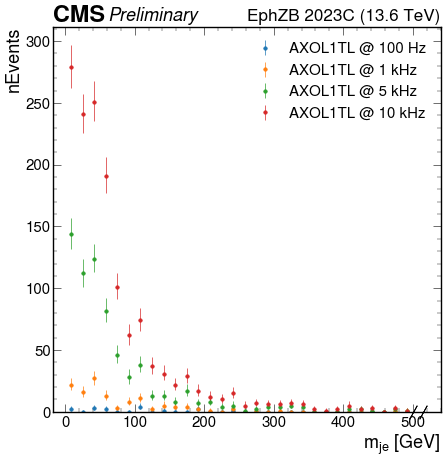

In [108]:
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=True, lumi=None, year='EphZB 2023C', com=13.6)
(mje_result['EphZeroBias_2023C']['hists']['mJetElectron_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz')
(mje_result['EphZeroBias_2023C']['hists']['mJetElectron_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz')
(mje_result['EphZeroBias_2023C']['hists']['mJetElectron_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz')
(mje_result['EphZeroBias_2023C']['hists']['mJetElectron_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz')
# ax.set_xlim(0, 200)
plt.ylabel('nEvents', loc='top')
ax.legend();

In [110]:
mjj_result.keys()

dict_keys(['EphZeroBias_2023C', 'QCD-4Jets_HT-200to400', 'VBFHToTauTau_M125', 'VBFHToInvisible_M-125', 'VBFHHto4B_CV-1_C2V-1_C3-1', 'SingleNeutrino_E-10-gun', 'JetMET0_slimmed', 'HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-500mm', 'HTo2LongLivedTo4mu_MH-125_MFF-20_CTau-13mm', 'HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm', 'HTo2LongLivedTo4b_MH-125_MFF-25_CTau-1500mm', 'HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm', 'HTo2LongLivedTo2mu2jets_MH-125_MFF-50_CTau-50mm', 'HTo2LongLivedTo2mu2jets_MH-125_MFF-20_CTau-13mm', 'HTo2LongLivedTo2mu2jets_MH-125_MFF-20_CTau-130mm', 'GluGluHToTauTau_M-125', 'GluGluHToGG_M-90', 'QCD_PT-30to80_bcToE'])

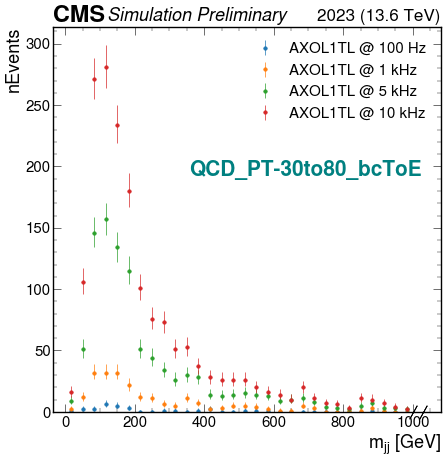

2023-12-13 19:33:24,786 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


In [145]:
sample = 'QCD_PT-30to80_bcToE'
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=False, lumi=None, year='2023', com=13.6)
(mjj_result[sample]['hists']['mJetJet_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz')
(mjj_result[sample]['hists']['mJetJet_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz')
(mjj_result[sample]['hists']['mJetJet_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz')
(mjj_result[sample]['hists']['mJetJet_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz')
# ax.set_xlim(0, 800)
ax.text(0.95, 0.6, sample, fontweight='bold', transform=ax.transAxes,
        verticalalignment='bottom', horizontalalignment='right',
        color='teal', fontsize=30)
plt.ylabel('nEvents', loc='top')
ax.legend();

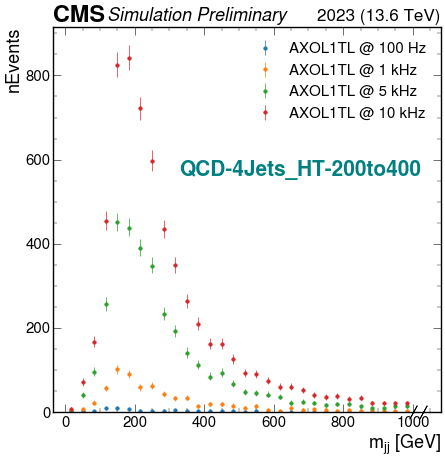

2023-12-13 19:47:37,251 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


In [154]:
sample = 'QCD-4Jets_HT-200to400'
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=False, lumi=None, year='2023', com=13.6)
(mjj_result[sample]['hists']['mJetJet_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz')
(mjj_result[sample]['hists']['mJetJet_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz')
(mjj_result[sample]['hists']['mJetJet_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz')
(mjj_result[sample]['hists']['mJetJet_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz')
# ax.set_xlim(0, 800)
ax.text(0.95, 0.6, sample, fontweight='bold', transform=ax.transAxes,
        verticalalignment='bottom', horizontalalignment='right',
        color='teal', fontsize=30)
plt.ylabel('nEvents', loc='top')
ax.legend();

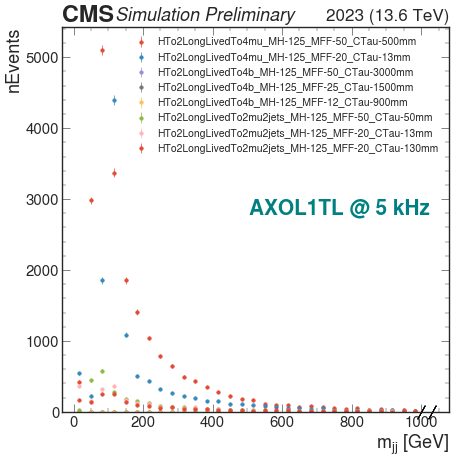

2023-12-13 19:54:47,225 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


In [160]:
samples = [s for s in mjj_result.keys() if ('HTo2LongLivedTo' in s)]
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=False, lumi=None, year='2023', com=13.6)
for s in samples:
    (mjj_result[s]['hists']['mJetJet_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label=f'{s}')
# ax.set_xlim(0, 800)
ax.text(0.95, 0.5, 'AXOL1TL @ 5 kHz', fontweight='bold', transform=ax.transAxes,
        verticalalignment='bottom', horizontalalignment='right',
        color='teal', fontsize=30)
plt.ylabel('nEvents', loc='top')
ax.legend(fontsize=15);